In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import torch

import sys
sys.path.append("../")

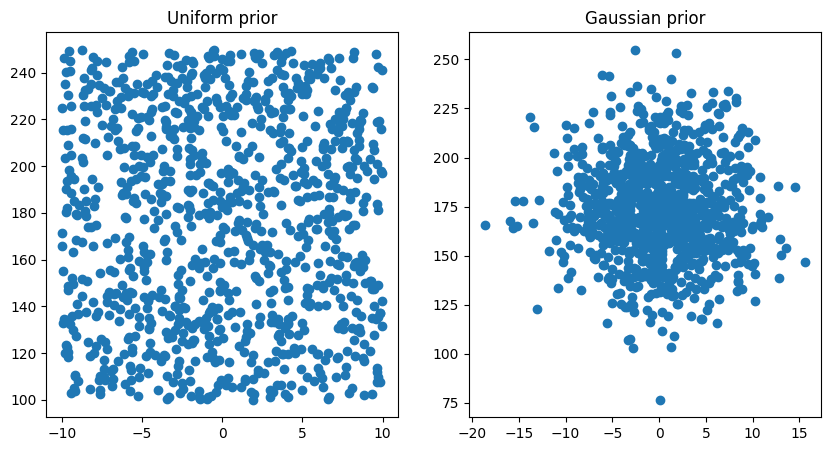

In [2]:
# Prior distributions
from tasks.toy_examples.prior import UniformPrior, GaussianPrior

prior_uniform = UniformPrior()
prior_gaussian = GaussianPrior()

# Plot prior distributions
samples_uniform = prior_uniform.sample((1000,))
samples_gaussian = prior_gaussian.sample((1000,))

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(samples_uniform[:, 0], samples_uniform[:, 1])
plt.title("Uniform prior")
plt.subplot(122)
plt.scatter(samples_gaussian[:, 0], samples_gaussian[:, 1])
plt.title("Gaussian prior") 
plt.show()

In [3]:
def euler_sde_sampler(score_fn, nsamples, beta, dim=2):
    theta_t = torch.randn((nsamples, dim))  # (nsamples, 2)
    time_pts = torch.linspace(1, 0, 1000)  # (ntime_pts,)
    for i in range(len(time_pts) - 1):
        t = time_pts[i]
        dt = time_pts[i + 1] - t

        # calculate the drift and diffusion terms
        f = -0.5 * beta(t) * theta_t
        g = beta(t) ** 0.5
        score = score_fn(theta_t, t).detach()
        drift = f - g * g * score
        diffusion = g

        # euler-maruyama step
        theta_t = theta_t + drift * dt + diffusion * torch.randn_like(theta_t) * torch.abs(dt) ** 0.5
    return theta_t.detach()

In [4]:
# Score functions
from nse import NSE
from vp_diffused_priors import get_vpdiff_uniform_score, get_vpdiff_gaussian_score

nse = NSE(2,2)
diffused_uniform_prior_score = get_vpdiff_uniform_score(prior_uniform.low, prior_uniform.high, nse)
diffused_gaussian_prior_score = get_vpdiff_gaussian_score(prior_gaussian.prior.loc, prior_gaussian.prior.covariance_matrix, nse)

In [5]:
samples_uniform_diffused = euler_sde_sampler(diffused_uniform_prior_score, 1000, nse.beta)
samples_gaussian_diffused = euler_sde_sampler(diffused_gaussian_prior_score, 1000, nse.beta)

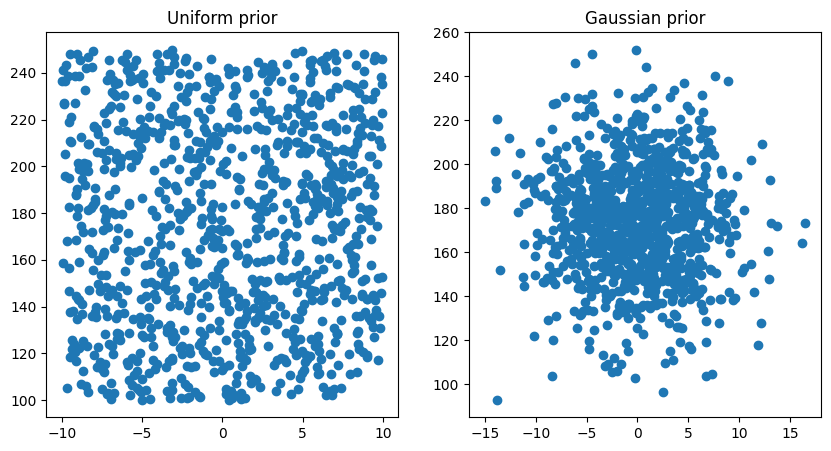

In [6]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(samples_uniform_diffused[:, 0], samples_uniform_diffused[:, 1])
plt.title("Uniform prior")
plt.subplot(122)
plt.scatter(samples_gaussian_diffused[:, 0], samples_gaussian_diffused[:, 1])
plt.title("Gaussian prior")
plt.show()


In [7]:
from tasks.sbibm.data_generators import get_task
task = get_task("sir")
prior = task.get_prior()

print(task.prior_dist.base_dist.loc)

samples = prior(1000)

# plt.scatter(samples[:, 0], samples[:, 1])
# plt.show()

transformed_samples = torch.log(samples)
print(transformed_samples.mean(0), samples.mean(0))
# transformed_samples_norm = (transformed_samples - transformed_samples.mean(0)) / transformed_samples.std(0)

# plt.scatter(transformed_samples_norm[:, 0], transformed_samples_norm[:, 1])
# plt.show()

tensor([-0.9163, -2.0794])
tensor([-0.9377, -2.0822]) tensor([0.4448, 0.1272])


/data/parietal/store3/work/jlinhart/miniconda3/envs/diff4sbi/lib/python3.10/site-packages/diffeqtorch/diffeqtorch.py:29: UserWarning: JULIA_SYSIMAGE_DIFFEQTORCH not set
  warn("JULIA_SYSIMAGE_DIFFEQTORCH not set")


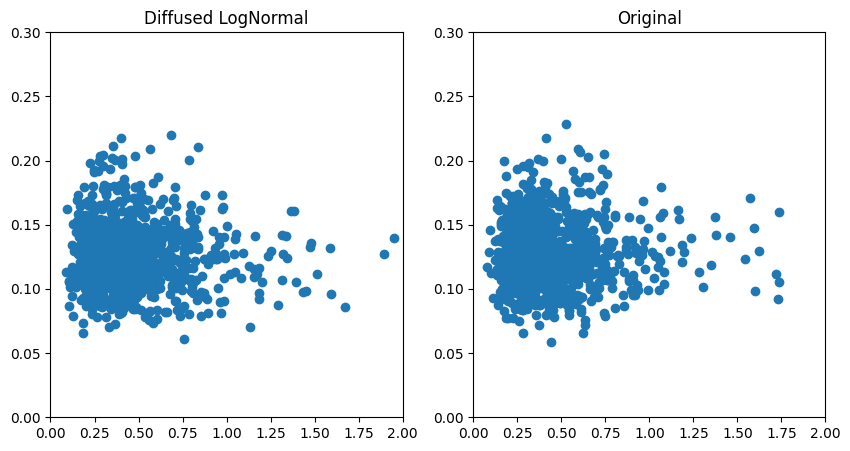

In [8]:
from tasks.sbibm.data_generators import get_task
task = get_task("sir")
prior = task.get_prior()

samples = prior(1000)
transformed_samples = torch.log(samples)
# samples_gauss = torch.distributions.Normal(task.prior_dist.base_dist.loc, task.prior_dist.base_dist.scale).sample((1000,))

loc = (task.prior_dist.base_dist.loc - transformed_samples.mean(0)) / transformed_samples.std(0)
cov = torch.diag(1 / transformed_samples.std(0)) @ torch.diag_embed(task.prior_dist.base_dist.scale.square()) @ torch.diag(1 / transformed_samples.std(0))

# samples_norm = torch.distributions.MultivariateNormal(loc, cov).sample((1000,))
# transformed_samples_norm = (transformed_samples - transformed_samples.mean(0)) / transformed_samples.std(0)

diffused_prior_score = get_vpdiff_gaussian_score(loc, cov, nse)

samples_lognormal_diffused = euler_sde_sampler(diffused_prior_score, 1000, nse.beta)
samples_lognormal_diffused = torch.exp(samples_lognormal_diffused * transformed_samples.std(0) + transformed_samples.mean(0))

# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# ax[0].scatter(transformed_samples[:, 0], transformed_samples[:, 1])
# ax[0].set_title("Log(X), X ~ LogNormal(m, s)")
# ax[1].scatter(samples_gauss[:, 0], samples_gauss[:, 1])
# ax[1].set_title("N(m, s)")
# plt.show()

# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# ax[0].scatter(transformed_samples_norm[:, 0], transformed_samples_norm[:, 1])
# ax[0].set_title("Log(X), X ~ LogNormal(0, 1)")
# ax[1].scatter(samples_norm[:, 0], samples_norm[:, 1])
# ax[1].set_title("N(0, 1)")
# plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(samples_lognormal_diffused[:, 0], samples_lognormal_diffused[:, 1])
ax[0].set_title("Diffused LogNormal")
ax[0].set_xlim(0, 2)
ax[0].set_ylim(0, 0.3)
ax[1].scatter(samples[:, 0], samples[:, 1])
ax[1].set_title("Original")
ax[1].set_xlim(0, 2)
ax[1].set_ylim(0, 0.3)
plt.show()

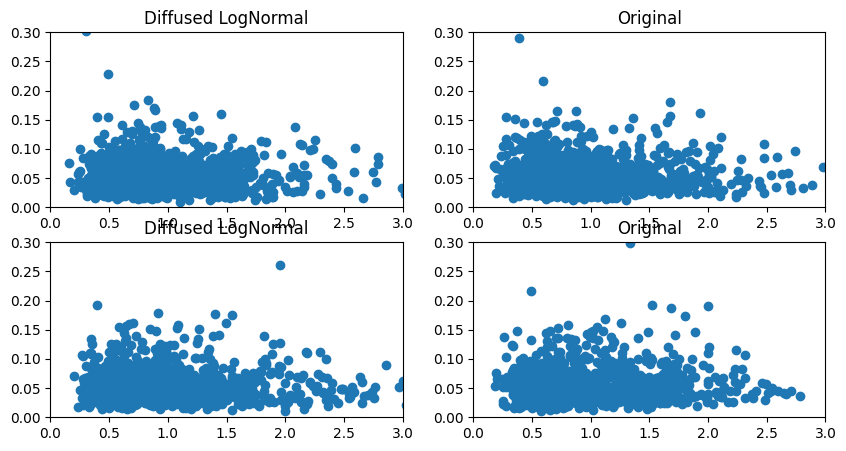

In [9]:
from tasks.sbibm.data_generators import get_task
task = get_task("lotka_volterra")
prior = task.get_prior()

samples = prior(1000)
transformed_samples = torch.log(samples)

loc = (task.prior_dist.base_dist.loc - transformed_samples.mean(0)) / transformed_samples.std(0)
cov = torch.diag(1 / transformed_samples.std(0)) @ torch.diag_embed(task.prior_dist.base_dist.scale.square()) @ torch.diag(1 / transformed_samples.std(0))

diffused_prior_score = get_vpdiff_gaussian_score(loc, cov, nse)

samples_lognormal_diffused = euler_sde_sampler(diffused_prior_score, 1000, nse.beta, dim=4)
samples_lognormal_diffused = torch.exp(samples_lognormal_diffused * transformed_samples.std(0) + transformed_samples.mean(0))

fig, ax = plt.subplots(2, 2, figsize=(10, 5))
ax[0, 0].scatter(samples_lognormal_diffused[:, 0], samples_lognormal_diffused[:, 1])
ax[0, 0].set_title("Diffused LogNormal")
ax[0, 0].set_xlim(0, 3)
ax[0, 0].set_ylim(0, 0.3)
ax[0, 1].scatter(samples[:, 0], samples[:, 1])
ax[0, 1].set_title("Original")
ax[0, 1].set_xlim(0, 3)
ax[0, 1].set_ylim(0, 0.3)
ax[1, 0].scatter(samples_lognormal_diffused[:, 2], samples_lognormal_diffused[:, 3])
ax[1, 0].set_title("Diffused LogNormal")
ax[1, 0].set_xlim(0, 3)
ax[1, 0].set_ylim(0, 0.3)
ax[1, 1].scatter(samples[:, 2], samples[:, 3])
ax[1, 1].set_title("Original")
ax[1, 1].set_xlim(0, 3)
ax[1, 1].set_ylim(0, 0.3)
plt.show()

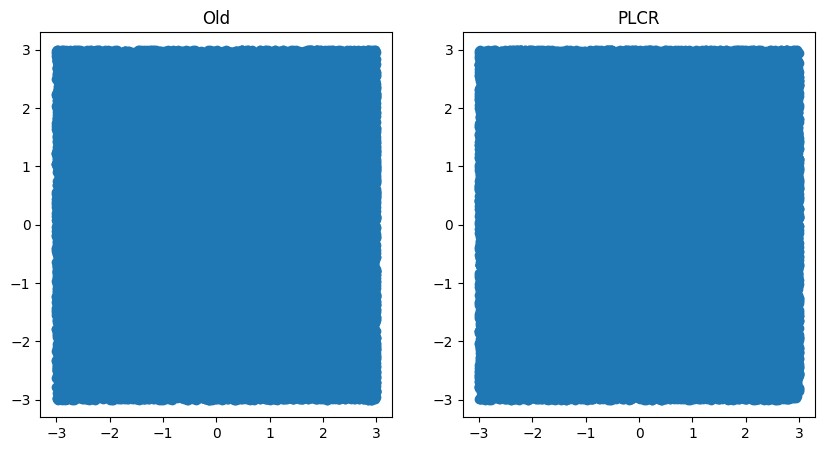

In [14]:
data = torch.load('/data/parietal/store3/work/jlinhart/git_repos/diffusions-for-sbi/results/sbibm/slcp_good/dataset_n_train_50000.pkl')
data_old = torch.load('/data/parietal/store3/work/jlinhart/git_repos/diffusions-for-sbi/results/sbibm/slcp/dataset_n_train_50000.pkl')
theta_train_old = data_old['theta']
x_train_old = data_old['x']
theta_train = data['theta']
x_train = data['x']

# theta_train = torch.log(theta_train)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(theta_train_old[:, 0], theta_train_old[:, 1])
ax[0].set_title("Old")
ax[1].scatter(theta_train[:, 0], theta_train[:, 1])
ax[1].set_title("PLCR")
plt.show()

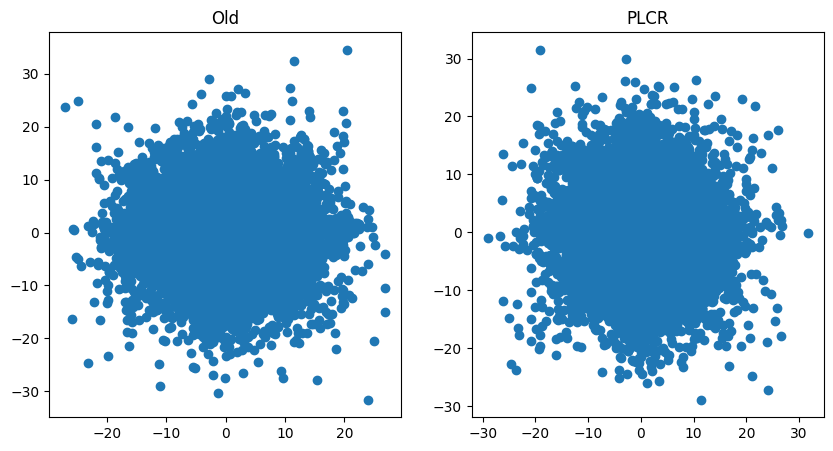

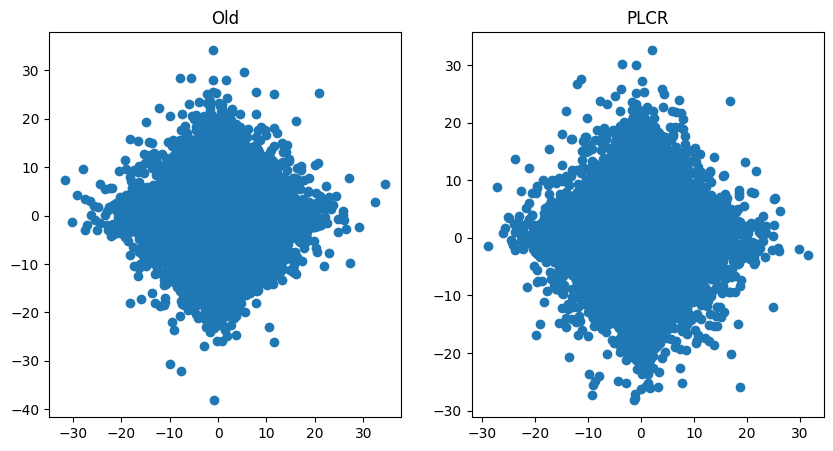

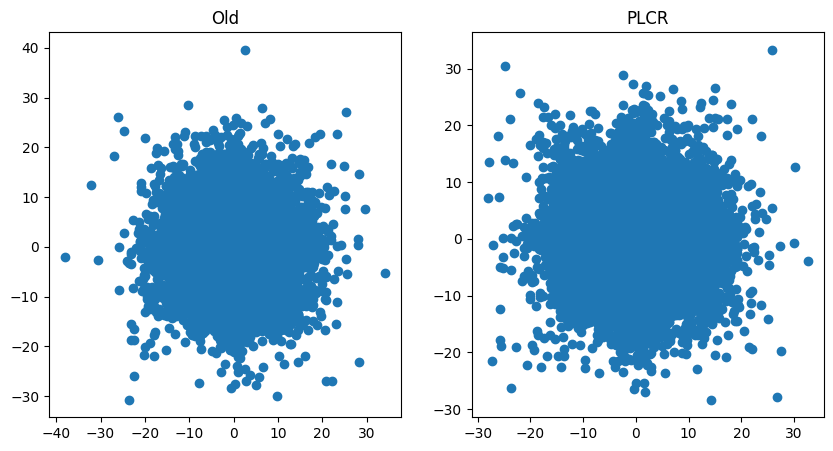

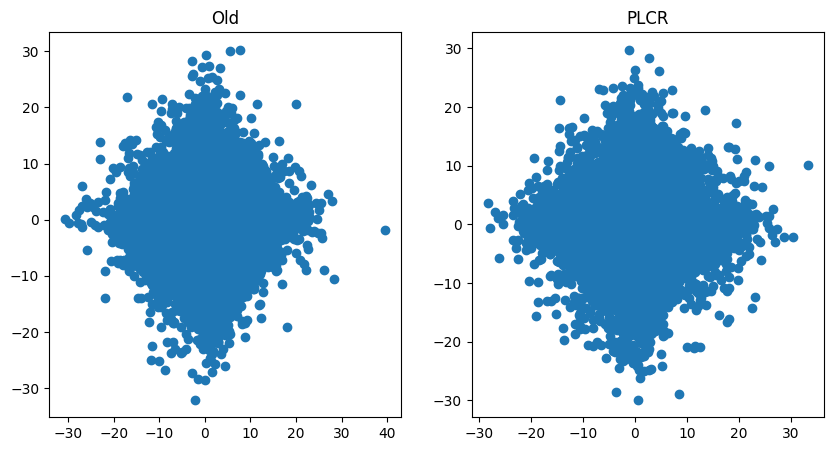

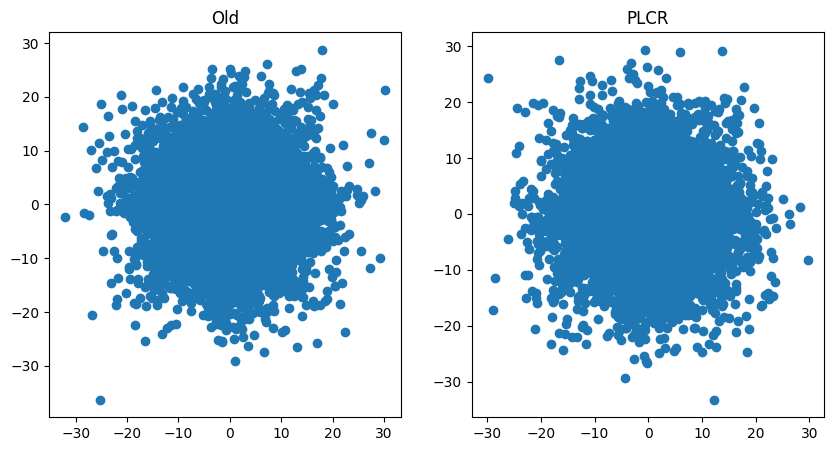

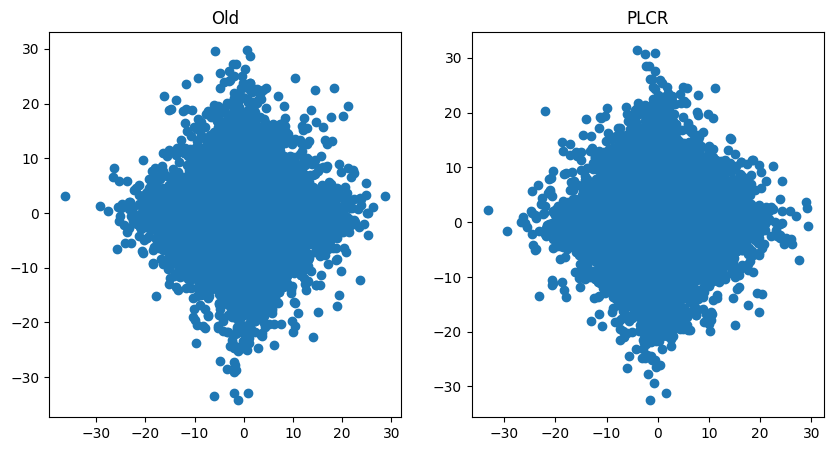

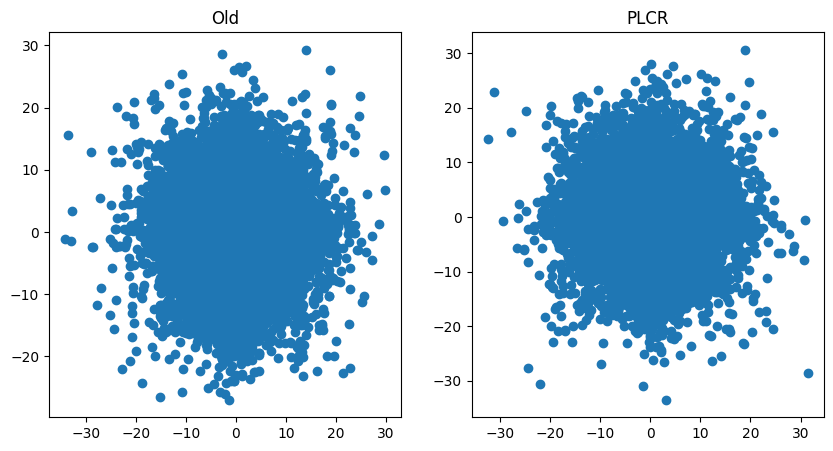

In [15]:
for i in range(7):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].scatter(x_train_old[:, i], x_train_old[:, i+1])
    ax[0].set_title("Old")
    ax[1].scatter(x_train[:, i], x_train[:, i+1])
    ax[1].set_title("PLCR")
    plt.show()